# Linear Regression and GLM Estimation Methods
---
## The four steps of causal inference

### I. Model a causal problem
- Create a causal DAG for your system of interest.

### II. Identify a target estimand under the model
- Identify the causal estimand under the assumptions of the causal DAG.

### III. Estimate the causal effect based on the identified estimand
- Estimate the estimand using any kind of Stats/ML model e.g. linear regression, random forest etc.

### IV. Refute the obtain estimate
- Peform refutations on the estimate to test its robustness 

## Imports

In [2]:
import numpy as np
import pandas as pd
import patsy as ps
import statsmodels
import dowhy
from dowhy import CausalModel
import econml
from IPython.display import Image, display
from pathlib import Path
import os
import sys
import pygraphviz

random_state = 42
# Avoid printing dataconversion warnings from sklearn
# Config dict to set the logging level
import logging.config
import warnings
warnings.filterwarnings('ignore')
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'WARN',
        },
    }
}
logging.config.dictConfig(DEFAULT_LOGGING)

# Import custom dowhy helper functions module
cwd = Path().resolve()
PARENT_DIR = os.path.dirname(cwd)
SCRIPT_DIR = os.path.join(PARENT_DIR, 'helpers')
sys.path.append(SCRIPT_DIR)
import dowhy_helpers as dwh

In [3]:
# I/O Stuff
DATA_FILENAME = "csdh_clean.csv"
DATA_FILEPATH = "/Users/callum/Uni/GitHubRepos/surviving-the-icu/datasets/drain_data/" + DATA_FILENAME
csdh = pd.read_csv(DATA_FILEPATH)
# Mapping bedrest to categorical variable
csdh['bedrest'] = csdh['bedrest'].map({'None':0, '<12hrs':1, '12-24hrs':2, '25-48hrs':3, '>48hrs':4})
# Drop NAs for DAG containing burrhole_num variable
csdh_burr = csdh.drop(csdh[csdh['burrhole_num'].isna()].index, axis=0)

---
## 0. Naïve Estimation (no causal inference)

In [4]:
csdh[csdh['drain']==1]

,age,sex,hospital,diabetes,dementia,copd,stroke,ihd,arrhythmia,epilepsy,...,drain_end,drain_entry,drain_days,timetoop_corrected,bedrest,recurrence,thickness_sum,thickness_avg,thickness_max,bilateral
1,23,1,1,0,0,0,0,0,0,0,...,1.0,1.0,2.0,15.0,0,0.0,6,6.0,6,0
2,23,0,26,0,0,0,0,0,0,0,...,1.0,NaN,2.0,5.0,3,0.0,22,11.0,13,1
5,29,1,17,0,0,0,0,0,0,0,...,2.0,NaN,2.0,1.0,2,0.0,30,30.0,30,0
6,32,0,9,0,0,0,0,0,0,0,...,1.0,2.0,2.0,8.0,0,1.0,10,10.0,10,0
8,34,0,18,0,0,0,0,0,0,0,...,2.0,2.0,1.0,0.0,2,0.0,8,8.0,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
740,96,0,18,0,0,0,0,0,0,0,...,2.0,2.0,2.0,1.0,2,0.0,26,26.0,26,0
741,96,0,3,0,1,0,0,0,0,0,...,1.0,NaN,1.0,5.0,1,0.0,18,18.0,18,0
742,97,1,4,0,0,0,0,0,0,0,...,1.0,NaN,1.0,1.0,2,0.0,42,21.0,28,1
743,98,1,18,0,0,0,0,0,0,0,...,1.0,2.0,2.0,3.0,2,0.0,30,30.0,30,0


In [6]:
csdh_burr[csdh_burr['drain']==0]

,age,sex,hospital,diabetes,dementia,copd,stroke,ihd,arrhythmia,epilepsy,...,drain_end,drain_entry,drain_days,timetoop_corrected,bedrest,recurrence,thickness_sum,thickness_avg,thickness_max,bilateral
0,20,1,17,0,0,0,0,0,0,1,...,NaN,NaN,NaN,15.0,0,1.0,20,20.0,20,0
3,23,1,17,0,0,0,0,0,0,0,...,NaN,NaN,NaN,10.0,0,0.0,8,8.0,8,0
4,28,1,26,0,0,0,0,0,0,0,...,NaN,NaN,NaN,0.0,2,0.0,10,10.0,10,0
7,33,1,1,0,0,0,0,0,0,0,...,NaN,NaN,NaN,2.0,0,0.0,25,12.5,19,1
10,34,1,13,0,0,0,0,0,0,0,...,NaN,NaN,NaN,13.0,2,0.0,12,12.0,12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670,89,0,6,0,0,0,1,0,0,0,...,NaN,NaN,NaN,2.0,0,0.0,19,19.0,19,0
721,93,1,13,0,0,0,0,1,0,0,...,NaN,NaN,NaN,1.0,3,0.0,21,21.0,21,0
726,94,1,21,0,0,0,0,0,1,0,...,NaN,NaN,NaN,2.0,1,0.0,23,23.0,23,0
732,94,0,6,0,1,0,1,1,0,0,...,NaN,NaN,NaN,1.0,0,0.0,32,32.0,32,0


In [15]:
# Dataset without dropping burrhole_num NA patients
naive_est = dwh.naive_estimate(df=csdh, treatment='drain', outcome='recurrence', treatment_type='int')
print(f"Without adjusting for any confounding, the naive causal estimate is computed as {naive_est}")

Without adjusting for any confounding, the naive causal estimate is computed as -0.09356128931064231


In [16]:
# Dataset after dropping patients with missing burrhole_num
naive_est_burr = dwh.naive_estimate(df=csdh_burr, treatment='drain', outcome='recurrence', treatment_type='int')
print(f"Without adjusting for any confounding, the naive causal estimate is computed as {naive_est_burr}")

Without adjusting for any confounding, the naive causal estimate is computed as -0.08374644024891888


---
## I. Model a causal problem
* Create a causal model from the data and given graph.

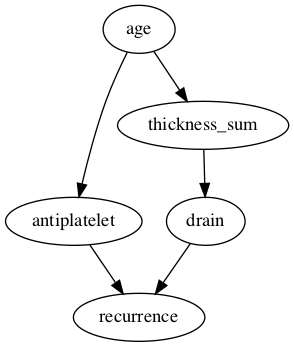

In [17]:
min_model = CausalModel(data=csdh, 
                        treatment='drain', 
                        outcome='recurrence', 
                        graph='../causal_graphs/min_dag.dot'.replace("\n", " "))
min_model.view_model()
display(Image(filename="causal_model.png"))

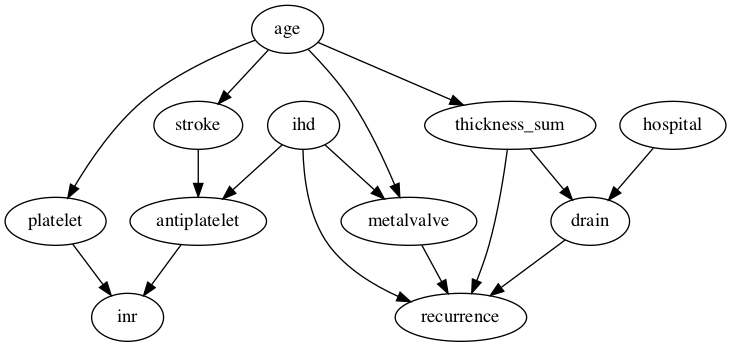

In [18]:
data_model = CausalModel(data=csdh, 
                         treatment='drain', 
                         outcome='recurrence', 
                         graph='../causal_graphs/small_data_dag.dot'.replace("\n", " "))
data_model.view_model()
display(Image(filename="causal_model.png"))

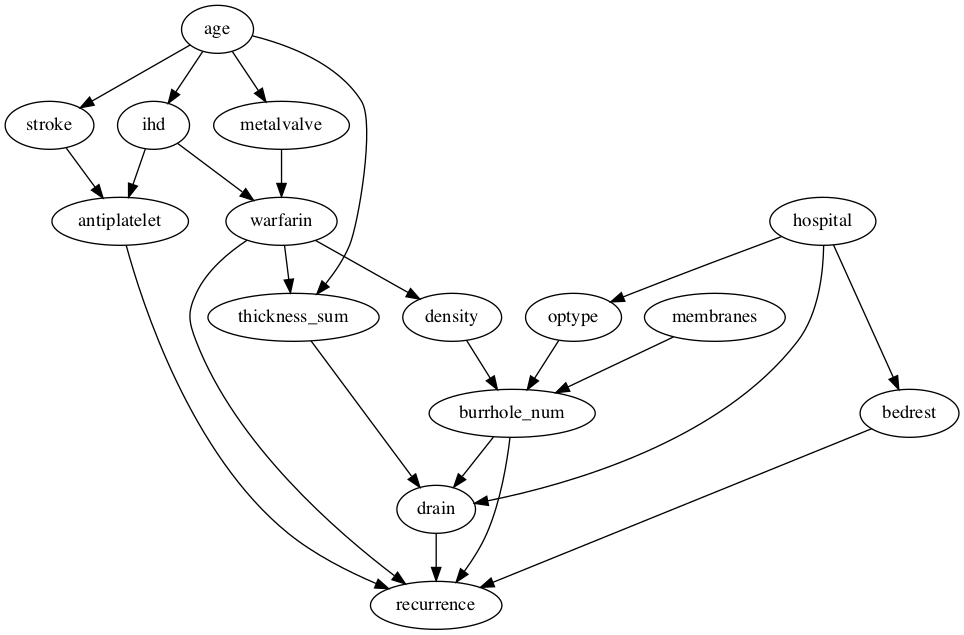

In [19]:
doc_model = CausalModel(data=csdh_burr, 
                         treatment='drain', 
                         outcome='recurrence', 
                         graph='../causal_graphs/doctor_dag.dot'.replace("\n", " "))
doc_model.view_model()
display(Image(filename="causal_model.png"))

---
## II. Identify a target estimand under the model

In [20]:
min_estimand = min_model.identify_effect(proceed_when_unidentifiable=True)
data_estimand = data_model.identify_effect(proceed_when_unidentifiable=True)
doc_estimand = doc_model.identify_effect(proceed_when_unidentifiable=True)

In [21]:
print(min_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                            
────────(Expectation(recurrence|antiplatelet,thickness_sum,age))
d[drain]                                                        
Estimand assumption 1, Unconfoundedness: If U→{drain} and U→recurrence then P(recurrence|drain,antiplatelet,thickness_sum,age,U) = P(recurrence|drain,antiplatelet,thickness_sum,age)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [22]:
print(data_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(recurrence|antiplatelet,thickness_sum,inr,platelet,stroke
d[drain]                                                                      

                     
,metalvalve,ihd,age))
                     
Estimand assumption 1, Unconfoundedness: If U→{drain} and U→recurrence then P(recurrence|drain,antiplatelet,thickness_sum,inr,platelet,stroke,metalvalve,ihd,age,U) = P(recurrence|drain,antiplatelet,thickness_sum,inr,platelet,stroke,metalvalve,ihd,age)

### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(recurrence, [hospital])*Derivative([drain], [hospital])
**(-1))
Estimand assumption 1, As-if-random: If U→→recurrence then ¬(U →→{hospital})
Estimand assumption 2, Exclusion: If we remove {hospital}→{drain}, then ¬({hospital}→recurrence)

### Estimand : 3
Estimand nam

In [24]:
print(doc_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(recurrence|antiplatelet,thickness_sum,hospital,density,ag
d[drain]                                                                      

                                                                        
e,membranes,bedrest,burrhole_num,stroke,optype,metalvalve,ihd,warfarin))
                                                                        
Estimand assumption 1, Unconfoundedness: If U→{drain} and U→recurrence then P(recurrence|drain,antiplatelet,thickness_sum,hospital,density,age,membranes,bedrest,burrhole_num,stroke,optype,metalvalve,ihd,warfarin,U) = P(recurrence|drain,antiplatelet,thickness_sum,hospital,density,age,membranes,bedrest,burrhole_num,stroke,optype,metalvalve,ihd,warfarin)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: 

---
## III. Linear Regression Estimator

In [25]:
# III. Estimate the target estimand using a statistical method.
min_lin_est = dwh.linear_regression_estimator(min_model, min_estimand, ci=True, test_significance=True)
data_lin_est = dwh.linear_regression_estimator(data_model, data_estimand, ci=True, test_significance=True)
doc_lin_est = dwh.linear_regression_estimator(doc_model, doc_estimand, ci=True, test_significance=True)

In [26]:
print(min_lin_est)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                            
────────(Expectation(recurrence|antiplatelet,thickness_sum,age))
d[drain]                                                        
Estimand assumption 1, Unconfoundedness: If U→{drain} and U→recurrence then P(recurrence|drain,antiplatelet,thickness_sum,age,U) = P(recurrence|drain,antiplatelet,thickness_sum,age)

## Realized estimand
b: recurrence~drain+antiplatelet+thickness_sum+age+drain*antiplatelet
Target units: ate

## Estimate
Mean value: -0.10067365926797883
p-value: [0.0222125]
95.0% confidence interval: [[-0.14110313 -0.01088982]]
### Conditional Estimates
__categorical__antiplatelet
(-0.001, 1.0]   -0.100674
dtype: float64


In [27]:
print(data_lin_est)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(recurrence|antiplatelet,thickness_sum,inr,platelet,stroke
d[drain]                                                                      

                     
,metalvalve,ihd,age))
                     
Estimand assumption 1, Unconfoundedness: If U→{drain} and U→recurrence then P(recurrence|drain,antiplatelet,thickness_sum,inr,platelet,stroke,metalvalve,ihd,age,U) = P(recurrence|drain,antiplatelet,thickness_sum,inr,platelet,stroke,metalvalve,ihd,age)

## Realized estimand
b: recurrence~drain+antiplatelet+thickness_sum+inr+platelet+stroke+metalvalve+ihd+age+drain*metalvalve+drain*ihd
Target units: ate

## Estimate
Mean value: -0.10849711522588264
p-value: [0.02185382]
95.0% confidence interval: [[-0.1382241  -0.01085408]]
### Conditional Estimate

In [28]:
print(doc_lin_est)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(recurrence|antiplatelet,thickness_sum,hospital,density,ag
d[drain]                                                                      

                                                                        
e,membranes,bedrest,burrhole_num,stroke,optype,metalvalve,ihd,warfarin))
                                                                        
Estimand assumption 1, Unconfoundedness: If U→{drain} and U→recurrence then P(recurrence|drain,antiplatelet,thickness_sum,hospital,density,age,membranes,bedrest,burrhole_num,stroke,optype,metalvalve,ihd,warfarin,U) = P(recurrence|drain,antiplatelet,thickness_sum,hospital,density,age,membranes,bedrest,burrhole_num,stroke,optype,metalvalve,ihd,warfarin)

## Realized estimand
b: recurrence~drain+ant

In [13]:
# mp model
dwh.print_estimate_comparison(naive_est, min_lin_est, 'Linear regression')

-------------- Causal Estimates -------------- 
Naive causal estimate is -0.09356128931064231
Linear regression causal estimate is -0.10067365926797882
Percentage change from naive_est: 7.602%
----------------------------------------------


In [14]:
# small data model
dwh.print_estimate_comparison(naive_est, data_lin_est, 'Linear regression')

-------------- Causal Estimates -------------- 
Naive causal estimate is -0.09356128931064231
Linear regression causal estimate is -0.10849711522588244
Percentage change from naive_est: 15.964%
----------------------------------------------


In [15]:
# data model
dwh.print_estimate_comparison(naive_est_burr, doc_lin_est, 'Linear regression')

-------------- Causal Estimates -------------- 
Naive causal estimate is -0.08374644024891888
Linear regression causal estimate is -0.08501222205697205
Percentage change from naive_est: 1.511%
----------------------------------------------


---
## IV. Refute the obtained estimate

1. **Add Random Common Cause:** Does the estimation method change its estimate after we add an independent random variable as a common cause to the dataset? (Hint: It should not)

In [16]:
# Robust if: estimate stays the same
lin_ran_refuter = min_model.refute_estimate(min_estimand, 
                                            min_lin_est, 
                                            random_state=random_state,
                                            method_name="random_common_cause", 
                                            num_simulations=100)

In [17]:
lin_ran_refuter_data = data_model.refute_estimate(data_estimand, 
                                                  data_lin_est, 
                                                  random_state=random_state,
                                                  method_name="random_common_cause", 
                                                  num_simulations=100)

In [18]:
lin_ran_refuter_doc = doc_model.refute_estimate(doc_estimand, 
                                                doc_lin_est, 
                                                random_state=random_state,
                                                method_name="random_common_cause", 
                                                num_simulations=100)

In [19]:
print(lin_ran_refuter)
print(lin_ran_refuter_data)
print(lin_ran_refuter_doc)

Refute: Add a Random Common Cause
Estimated effect:-0.10067365926797882
New effect:-0.10078637993765123

Refute: Add a Random Common Cause
Estimated effect:-0.10849711522588244
New effect:-0.10897022887410167

Refute: Add a Random Common Cause
Estimated effect:-0.08501222205697205
New effect:-0.08755850401419282



2. **Placebo Treatment:** What happens to the estimated causal effect when we replace the true treatment variable with an independent random variable? (Hint: the effect should go to zero)



* Note that the placebo type is 'permute' meaning the rows of the treatment variable have been randomly permuted giving the effect of a placebo treatment.


In [20]:
# Robust if: estimate goes to 0
lin_placebo_refuter = min_model.refute_estimate(min_estimand, min_lin_est, 
                                                method_name="placebo_treatment_refuter",
                                                num_simulations=100,
                                                placebo_type='permute')

lin_placebo_refuter_data = data_model.refute_estimate(data_estimand, data_lin_est, 
                                                      method_name="placebo_treatment_refuter",
                                                      num_simulations=100, 
                                                      placebo_type='permute')

lin_placebo_refuter_doc = doc_model.refute_estimate(doc_estimand, doc_lin_est, 
                                                    method_name="placebo_treatment_refuter",
                                                    num_simulations=100, 
                                                    placebo_type='permute')

In [21]:
print(lin_placebo_refuter)
print(lin_placebo_refuter_data)
print(lin_placebo_refuter_doc)

Refute: Use a Placebo Treatment
Estimated effect:-0.10067365926797882
New effect:-0.0017818823362914836
p value:0.5

Refute: Use a Placebo Treatment
Estimated effect:-0.10849711522588244
New effect:0.00306425678415774
p value:0.42

Refute: Use a Placebo Treatment
Estimated effect:-0.08501222205697205
New effect:0.001543910698303337
p value:0.45



3. **Dummy Outcome:** What happens to the estimated causal effect when we replace the true outcome variable with an independent random variable? (Hint: The effect should go to zero)



* The result shows that when using a dummy outcome, the **treatment does not lead to the outcome**. The estimated effect is hence a value that tends to zero, which matches our expectation. This shows that if we replace the outcome by randomly generated data, the **estimator correctly predicts that the influence if treatment is zero**.


In [22]:
# Robust if: estimate goes to 0
lin_dummy_refuter = min_model.refute_estimate(min_estimand, min_lin_est, 
                                              method_name="dummy_outcome_refuter",
                                              random_state=random_state,
                                              num_simulations=100)

lin_dummy_refuter_data = data_model.refute_estimate(data_estimand, data_lin_est,
                                                    method_name="dummy_outcome_refuter",
                                                    random_state=random_state,
                                                    num_simulations=100)

lin_dummy_refuter_doc = doc_model.refute_estimate(doc_estimand, doc_lin_est,
                                                  method_name="dummy_outcome_refuter",
                                                  random_state=random_state,
                                                  num_simulations=100)


In [23]:
print(lin_dummy_refuter[0])
print(lin_dummy_refuter_data[0])
print(lin_dummy_refuter_doc[0])

Refute: Use a Dummy Outcome
Estimated effect:0
New effect:-0.0054075400502844526
p value:0.45999999999999996

Refute: Use a Dummy Outcome
Estimated effect:0
New effect:-0.0005922079482488152
p value:0.5

Refute: Use a Dummy Outcome
Estimated effect:0
New effect:0.027724366204380235
p value:0.45



4. **Data Subsets Validation:** Does the estimated effect change significantly when we replace the given dataset with a randomly selected subset? (Hint: It should not)

In [24]:
# Robust if: estimate stays the same
lin_subset_refuter = min_model.refute_estimate(min_estimand, min_lin_est, 
                                               method_name="data_subset_refuter",
                                               random_state=random_state,
                                               num_simulations=100,
                                               subset_fraction=0.75)

lin_subset_refuter_data = data_model.refute_estimate(data_estimand, data_lin_est, 
                                                     method_name="data_subset_refuter",
                                                     random_state=random_state,
                                                     num_simulations=100,
                                                     subset_fraction=0.75)

In [25]:
lin_subset_refuter_doc = doc_model.refute_estimate(doc_estimand, doc_lin_est, 
                                                   method_name="data_subset_refuter",
                                                   random_state=random_state,
                                                   num_simulations=100,
                                                   subset_fraction=0.75)

In [26]:
print(lin_subset_refuter)
print(lin_subset_refuter_data)
print(lin_subset_refuter_doc)

Refute: Use a subset of data
Estimated effect:-0.10067365926797882
New effect:-0.08803124971236846
p value:0.0

Refute: Use a subset of data
Estimated effect:-0.10849711522588244
New effect:-0.09932980866605341
p value:0.0

Refute: Use a subset of data
Estimated effect:-0.08501222205697205
New effect:-0.0779591755683984
p value:0.0



5. **Bootstrap Validation:** Does the estimated effect change significantly when we replace the given dataset with bootstrapped samples from the same dataset? (Hint: It should not)

In [27]:
# Robust if: estimate stays the same
lin_bootstrap_refuter = min_model.refute_estimate(min_estimand, min_lin_est, 
                                                  method_name="bootstrap_refuter",
                                                  random_state=random_state,
                                                  num_simulations=100)

lin_bootstrap_refuter_data = data_model.refute_estimate(data_estimand, data_lin_est, 
                                                        method_name="bootstrap_refuter",
                                                        random_state=random_state,
                                                        num_simulations=100)

lin_bootstrap_refuter_doc = doc_model.refute_estimate(doc_estimand, doc_lin_est, 
                                                      method_name="bootstrap_refuter",
                                                      random_state=random_state,
                                                      num_simulations=100)

In [28]:
print(lin_bootstrap_refuter)
print(lin_bootstrap_refuter_data)
print(lin_bootstrap_refuter_doc)

Refute: Bootstrap Sample Dataset
Estimated effect:-0.10067365926797882
New effect:-0.14500821397256186
p value:0.0

Refute: Bootstrap Sample Dataset
Estimated effect:-0.10849711522588244
New effect:-0.17277437798590944
p value:0.0

Refute: Bootstrap Sample Dataset
Estimated effect:-0.08501222205697205
New effect:-0.12207728189876649
p value:0.0



---
## III. Generalized linear model (GLM) estimator


In [29]:
min_glm_est = dwh.bin_glm_estimator(min_model, min_estimand, ci=True, test_significance=True)

In [30]:
data_glm_est = dwh.bin_glm_estimator(data_model, data_estimand, ci=True, test_significance=True)

In [31]:
doc_glm_est = dwh.bin_glm_estimator(doc_model, doc_estimand, ci=True, test_significance=True)

In [32]:
print(min_glm_est)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                            
────────(Expectation(recurrence|thickness_sum,age,antiplatelet))
d[drain]                                                        
Estimand assumption 1, Unconfoundedness: If U→{drain} and U→recurrence then P(recurrence|drain,thickness_sum,age,antiplatelet,U) = P(recurrence|drain,thickness_sum,age,antiplatelet)

## Realized estimand
b: recurrence~Sigmoid(drain+thickness_sum+age+antiplatelet+drain*antiplatelet)
Target units: ate

## Estimate
Mean value: -0.10223455200046452
p-value: 0.001
95.0% confidence interval: (-0.16176800308908712, -0.04502853186658157)
### Conditional Estimates
__categorical__antiplatelet
(-0.001, 1.0]   -0.102235
dtype: float64


In [33]:
print(data_glm_est)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(recurrence|age,metalvalve,ihd,platelet,stroke,thickness_s
d[drain]                                                                      

                     
um,antiplatelet,inr))
                     
Estimand assumption 1, Unconfoundedness: If U→{drain} and U→recurrence then P(recurrence|drain,age,metalvalve,ihd,platelet,stroke,thickness_sum,antiplatelet,inr,U) = P(recurrence|drain,age,metalvalve,ihd,platelet,stroke,thickness_sum,antiplatelet,inr)

## Realized estimand
b: recurrence~Sigmoid(drain+age+metalvalve+ihd+platelet+stroke+thickness_sum+antiplatelet+inr+drain*metalvalve+drain*ihd)
Target units: ate

## Estimate
Mean value: -0.11013202824957304
p-value: [0, 0.001]
95.0% confidence interval: (-0.1550541856481507, -0.05856583484919227)
#

In [34]:
print(doc_glm_est)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(Expectation(recurrence|hospital,age,metalvalve,ihd,burrhole_num,strok
d[drain]                                                                      

                                                                        
e,thickness_sum,antiplatelet,bedrest,density,membranes,warfarin,optype))
                                                                        
Estimand assumption 1, Unconfoundedness: If U→{drain} and U→recurrence then P(recurrence|drain,hospital,age,metalvalve,ihd,burrhole_num,stroke,thickness_sum,antiplatelet,bedrest,density,membranes,warfarin,optype,U) = P(recurrence|drain,hospital,age,metalvalve,ihd,burrhole_num,stroke,thickness_sum,antiplatelet,bedrest,density,membranes,warfarin,optype)

## Realized estimand
b: recurrence~Sigmoid(d

In [35]:
# mp model
dwh.print_estimate_comparison(naive_est, min_glm_est, 'Binomial GLM')

-------------- Causal Estimates -------------- 
Naive causal estimate is -0.09356128931064231
Binomial GLM causal estimate is -0.10223455200046452
Percentage change from naive_est: 9.27%
----------------------------------------------


In [36]:
# mp model
dwh.print_estimate_comparison(naive_est, data_glm_est, 'Binomial GLM')

-------------- Causal Estimates -------------- 
Naive causal estimate is -0.09356128931064231
Binomial GLM causal estimate is -0.11013202824957304
Percentage change from naive_est: 17.711%
----------------------------------------------


In [37]:
# mp model
dwh.print_estimate_comparison(naive_est_burr, doc_glm_est, 'Binomial GLM')

-------------- Causal Estimates -------------- 
Naive causal estimate is -0.08374644024891888
Binomial GLM causal estimate is -0.089481567363489
Percentage change from naive_est: 6.848%
----------------------------------------------


---
## IV. Refute the obtained estimate

1. **Add Random Common Cause:** Does the estimation method change its estimate after we add an independent random variable as a common cause to the dataset? (Hint: It should not)

In [39]:
# Robust if: estimate stays the same
glm_ran_refuter = min_model.refute_estimate(min_estimand, min_glm_est, 
                                           method_name="random_common_cause",
                                            random_state=random_state,
                                           num_simulations=100)

In [40]:
glm_ran_refuter_data = data_model.refute_estimate(data_estimand, data_glm_est, 
                                                  method_name="random_common_cause",
                                                  random_state=random_state,
                                                  num_simulations=100)

In [41]:
glm_ran_refuter_doc = doc_model.refute_estimate(doc_estimand, doc_glm_est, 
                                                method_name="random_common_cause", 
                                                random_state=random_state,
                                                num_simulations=100)

In [42]:
print(glm_ran_refuter)
print(glm_ran_refuter_data)
print(glm_ran_refuter_doc)

Refute: Add a Random Common Cause
Estimated effect:-0.10223455200046452
New effect:-0.1020681721653284

Refute: Add a Random Common Cause
Estimated effect:-0.11013202824957304
New effect:-0.10908355669957608

Refute: Add a Random Common Cause
Estimated effect:-0.089481567363489
New effect:-0.08840152525066729



2. **Placebo Treatment:** What happens to the estimated causal effect when we replace the true treatment variable with an independent random variable? (Hint: the effect should go to zero)



* Note that the placebo type is 'permute' meaning the rows of the treatment variable have been randomly permuted giving the effect of a placebo treatment.


In [43]:
# Robust if: estimate goes to 0
glm_placebo_refuter = min_model.refute_estimate(min_estimand, min_glm_est,
                                                method_name="placebo_treatment_refuter",
                                                num_simulations=100,
                                                placebo_type='permute')

In [44]:
glm_placebo_refuter_data = data_model.refute_estimate(data_estimand, data_glm_est,
                                                      method_name="placebo_treatment_refuter",
                                                      num_simulations=100,
                                                      placebo_type='permute')

In [45]:
glm_placebo_refuter_doc = doc_model.refute_estimate(doc_estimand, doc_glm_est,
                                                      method_name="placebo_treatment_refuter",
                                                      num_simulations=100,
                                                      placebo_type='permute')

In [46]:
print(glm_placebo_refuter)
print(glm_placebo_refuter_data)
print(glm_placebo_refuter_doc)

Refute: Use a Placebo Treatment
Estimated effect:-0.10223455200046452
New effect:0.003826568736197888
p value:0.37

Refute: Use a Placebo Treatment
Estimated effect:-0.11013202824957304
New effect:-0.0013890838962148488
p value:0.45999999999999996

Refute: Use a Placebo Treatment
Estimated effect:-0.089481567363489
New effect:-0.0026399424073416367
p value:0.5



3. **Dummy Outcome:** What happens to the estimated causal effect when we replace the true outcome variable with an independent random variable? (Hint: The effect should go to zero)



* The result shows that when using a dummy outcome, the **treatment does not lead to the outcome**. The estimated effect is hence a value that tends to zero, which matches our expectation. This shows that if we replace the outcome by randomly generated data, the **estimator correctly predicts that the influence if treatment is zero**.

In [47]:
# Robust if: estimate goes to 0
glm_dummy_refuter = min_model.refute_estimate(min_estimand, min_glm_est,
                                             method_name="dummy_outcome_refuter", 
                                              random_state=random_state,
                                             num_simulations=100)

In [48]:
glm_dummy_refuter_data = data_model.refute_estimate(data_estimand, data_glm_est, 
                                                    method_name="dummy_outcome_refuter",
                                                    random_state=random_state,
                                                    num_simulations=100)

In [49]:
glm_dummy_refuter_doc = doc_model.refute_estimate(doc_estimand, doc_glm_est, 
                                                  method_name="dummy_outcome_refuter",
                                                  random_state=random_state,
                                                  num_simulations=100)

In [50]:
print(glm_dummy_refuter[0])
print(glm_dummy_refuter_data[0])
print(glm_dummy_refuter_doc[0])

Refute: Use a Dummy Outcome
Estimated effect:0
New effect:-0.013129861816760893
p value:0.79

Refute: Use a Dummy Outcome
Estimated effect:0
New effect:-0.035355704697986566
p value:0.47

Refute: Use a Dummy Outcome
Estimated effect:0
New effect:-0.051565656565656565
p value:0.27



4. **Data Subsets Validation:** Does the estimated effect change significantly when we replace the given dataset with a randomly selected subset? (Hint: It should not)

In [51]:
# Robust if: estimate stays the same
glm_subset_refuter = min_model.refute_estimate(min_estimand, min_glm_est, 
                                               method_name="data_subset_refuter", 
                                               random_state=random_state,
                                               subset_fraction=0.75, num_simulations=100)

In [52]:
glm_subset_refuter_data = data_model.refute_estimate(data_estimand, data_glm_est, 
                                                     method_name="data_subset_refuter",
                                                     random_state=random_state,
                                                     subset_fraction=0.75, num_simulations=100)

In [53]:
glm_subset_refuter_doc = doc_model.refute_estimate(doc_estimand, doc_glm_est, 
                                                   method_name="data_subset_refuter", 
                                                   random_state=random_state,
                                                   subset_fraction=0.75, 
                                                   num_simulations=100)

In [54]:
print(glm_subset_refuter)
print(glm_subset_refuter_data)
print(glm_subset_refuter_doc)

Refute: Use a subset of data
Estimated effect:-0.10223455200046452
New effect:-0.08664362318353941
p value:0.0

Refute: Use a subset of data
Estimated effect:-0.11013202824957304
New effect:-0.09804600027368045
p value:0.0

Refute: Use a subset of data
Estimated effect:-0.089481567363489
New effect:-0.08120884952964555
p value:0.0



5. **Bootstrap Validation:** Does the estimated effect change significantly when we replace the given dataset with bootstrapped samples from the same dataset? (Hint: It should not)

In [55]:
# Robust if: estimate stays the same
glm_bootstrap_refuter = min_model.refute_estimate(min_estimand, min_glm_est, 
                                                  method_name="bootstrap_refuter",
                                                  random_state=random_state,
                                                  num_simulations=100)

In [56]:
glm_bootstrap_refuter_data = data_model.refute_estimate(data_estimand, data_glm_est, 
                                                        method_name="bootstrap_refuter", 
                                                        random_state=random_state,
                                                        num_simulations=100)

In [57]:
glm_bootstrap_refuter_doc = doc_model.refute_estimate(doc_estimand, doc_glm_est, 
                                                      method_name="bootstrap_refuter", 
                                                      random_state=random_state,
                                                      num_simulations=100)

In [58]:
print(glm_bootstrap_refuter)
print(glm_bootstrap_refuter_data)
print(glm_bootstrap_refuter_doc)

Refute: Bootstrap Sample Dataset
Estimated effect:-0.10223455200046452
New effect:-0.1545526170268962
p value:0.0

Refute: Bootstrap Sample Dataset
Estimated effect:-0.11013202824957304
New effect:-0.18130039082857297
p value:0.0

Refute: Bootstrap Sample Dataset
Estimated effect:-0.089481567363489
New effect:-0.12884006252359614
p value:0.0

